In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm

from scipy.signal import savgol_filter

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


In [10]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/simulated_ant_dataset_3_2025-12-04.h5'

minimumLength = 10 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = False
excludeObjects = True

padding = None # mm
inversePadding = None # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength, smoothingWindow, maximumTimeSkip,
                                            excludeOutliers, excludeShortSegments, excludeObjects,
                                            padding, inversePadding, debug=True)

Loading SLEAP data: 100%|████████████████████| 100/100 [00:00<00:00, 326.41it/s]

Loaded 100 segments!


In [11]:
def computeAngles(trajectory, dt=1, minVelocityThreshold=1):
    # Compute the velocity for the trajectory
    velocityArr = (trajectory[1:] - trajectory[:-1]) / dt
    velocityMagnitudes = np.sqrt(np.sum(velocityArr**2, axis=-1))
    # Make unit vectors
    velocityArr[:,0] = velocityArr[:,0] / velocityMagnitudes
    velocityArr[:,1] = velocityArr[:,1] / velocityMagnitudes

    # Now take angle differences for the steps
    # The clip is to avoid numerical errors
    angleDifferenceArr = np.array([np.arccos(np.clip(np.dot(velocityArr[i], velocityArr[i+1]), -1., 1.)) for i in range(len(velocityArr)-1)])

    # To compute the sign of the angle, we need
    # to use the cross product
    signArr = np.array([np.sign(np.cross(velocityArr[i], velocityArr[i+1])) for i in range(len(velocityArr)-1)])
    angleDifferenceArr = angleDifferenceArr * signArr

    # Threshold, since tiny velocities could just be jitter
    angleDifferenceArr = angleDifferenceArr[velocityMagnitudes[1:] + velocityMagnitudes[:-1] > minVelocityThreshold]
    
    return angleDifferenceArr[~np.isnan(angleDifferenceArr)]

In [12]:
numBins = 50
skipFactor = 1
extraSmoothingKernel = 0
velocityThreshold = 3 # mm/s

# Find indices with no objects in the arena
objectsInArena = [m["objects"] == '[]' for m in metadataArr]
goodIndices = np.where(objectsInArena)[0]

angleArr = np.zeros((len(goodIndices), numBins))
allAngleArr = np.zeros(0)

bins = np.linspace(-np.pi, np.pi, numBins+1)
binArr = (bins[1:] + bins[:-1])/2

for i in tqdm(range(len(goodIndices))):
    meanData = dataArr[goodIndices[i]]

    # In case we want to smooth extra
    if extraSmoothingKernel > 1:
        smoothTrajectory = savgol_filter(meanData, extraSmoothingKernel, 1, axis=0)
    else:
        smoothTrajectory = meanData
        
    # Compute the angles
    angles = computeAngles(smoothTrajectory[::skipFactor],
                           dt=skipFactor/metadataArr[i]["fps"],
                           minVelocityThreshold=velocityThreshold)

    allAngleArr = np.concatenate((allAngleArr, angles))

    # Now compute the distributions
    angleArr[i], _ = np.histogram(angles, bins=bins, density=True)


  0%|                                                   | 0/100 [00:00<?, ?it/s]/tmp/ipykernel_101295/828684216.py:6: RuntimeWarning: invalid value encountered in divide
  velocityArr[:,0] = velocityArr[:,0] / velocityMagnitudes
/tmp/ipykernel_101295/828684216.py:7: RuntimeWarning: invalid value encountered in divide
  velocityArr[:,1] = velocityArr[:,1] / velocityMagnitudes
100%|█████████████████████████████████████████| 100/100 [01:39<00:00,  1.01it/s]


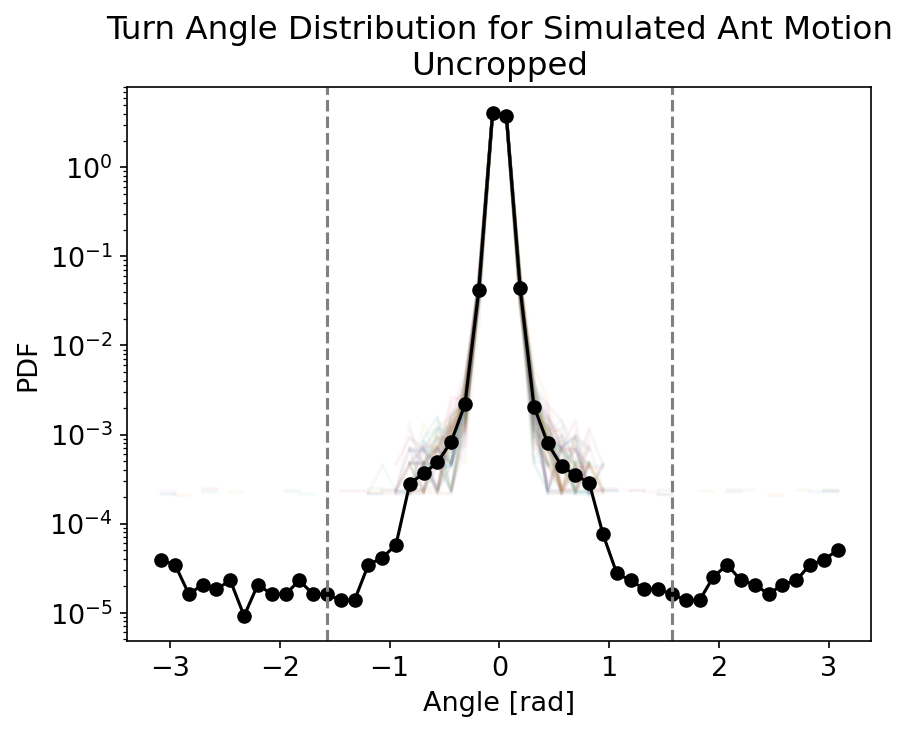

In [13]:
for i in range(len(goodIndices)):
    angles = np.where(angleArr[i] > 0, angleArr[i], np.nan)
    plt.plot(binArr, angles, alpha=0.05)

meanDist, meanBins = np.histogram(allAngleArr, bins=bins, density=True)
meanBins = (meanBins[1:] + meanBins[:-1])/2

plt.plot(meanBins, meanDist, '-o', c='black')

plt.axvline(np.pi/2, c='gray', linestyle='--')
plt.axvline(-np.pi/2, c='gray', linestyle='--')

plt.yscale('log')
#plt.ylim([1e-2, 5e0])
plt.ylabel('PDF')
plt.xlabel('Angle [rad]')
#plt.title('Turn Angle Distribution for Ant Motion\nNo walls (1cm)')
plt.title('Turn Angle Distribution for Simulated Ant Motion\nUncropped')
pltsaveall('simulated/04_RawTurnAngleDist')
plt.show()

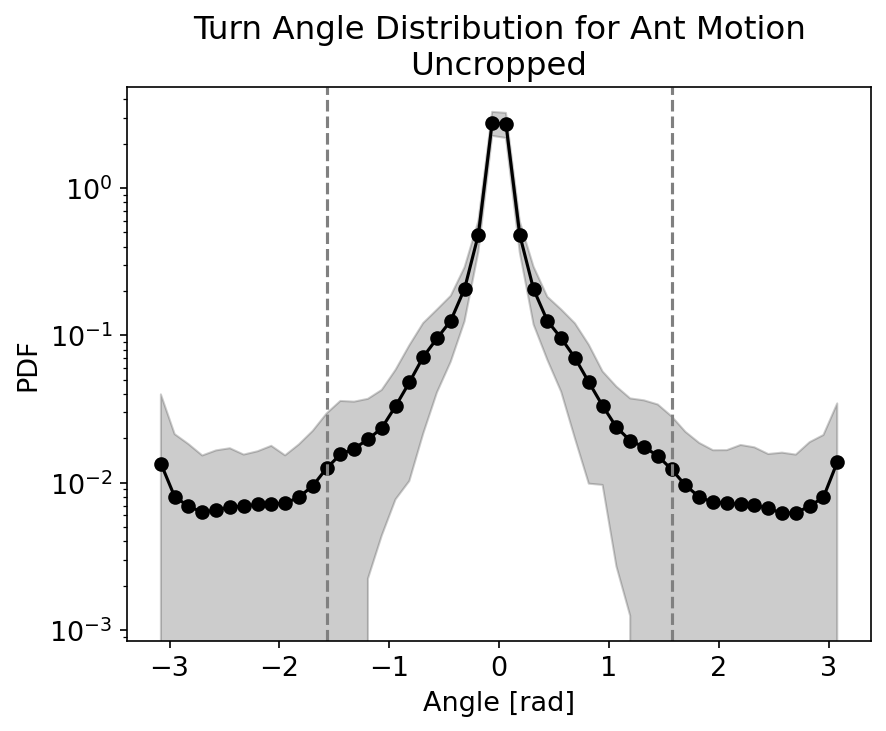

In [33]:

meanDist, meanBins = np.histogram(allAngleArr, bins=bins, density=True)
meanBins = (meanBins[1:] + meanBins[:-1])/2

meanErr = np.std(angleArr, axis=0)
plt.fill_between(meanBins, meanDist - meanErr, meanDist + meanErr, alpha=0.2, color='black')
plt.plot(meanBins, meanDist, '-o', c='black')

plt.axvline(np.pi/2, c='gray', linestyle='--')
plt.axvline(-np.pi/2, c='gray', linestyle='--')

plt.yscale('log')
#plt.ylim([1e-2, 5e0])
plt.ylabel('PDF')
plt.xlabel('Angle [rad]')
#plt.title('Turn Angle Distribution for Ant Motion\nNo walls (1cm)')
plt.title('Turn Angle Distribution for Ant Motion\nUncropped')
pltsaveall('04_RawTurnAngleDist_Err')
plt.show()